In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
import re
import concurrent.futures
from collections import Counter
import matplotlib.pyplot as plt
import string

### Movie database data loading

In [2]:
movie_data = pd.read_csv(r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\TxMM\project_data\movies_metadata.csv")
movie_data

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [3]:
md_titles_dates = movie_data.copy()[['title', 'release_date']]
md_titles_dates['title'] = md_titles_dates['title'].map(lambda x: str(x).lower())
md_titles_dates['title'] = md_titles_dates['title'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
md_titles_dates

,title,release_date
0,toy story,1995-10-30
1,jumanji,1995-12-15
2,grumpier old men,1995-12-22
3,waiting to exhale,1995-12-22
4,father of the bride part ii,1995-02-10
...,...,...
45461,subdue,NaN
45462,century of birthing,2011-11-17
45463,betrayal,2003-08-01
45464,satan triumphant,1917-10-21


### Subtitle loading and cleaning

In [4]:
srt_nontext = re.compile("(\d+\n[\d\:\,\W]+\n)|(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])|(<i>)|(<\/i>)|(\(([A-Z]\s*\W*l*[a-z]*)*\))") 
# Regex above is for '.srt' files - matches specific non-text lines (subtitle timing info etc.) and info for the 
# hearing impaired (which is not needed). Test/demo: https://regex101.com/r/HzgKov/7
sub_nontext = re.compile("\{\d*\}")
# Regex above is for '.sub' files - matches specific non-text elements. Test/demo: https://regex101.com/r/0wV1Q1/1
smi_nontext = re.compile("(<[\w*\d*\s*]*[^<]+[\w*\d*\s*]*>)")
# Regex above is for '.smi' files - matches specific non-text elements (subtitle timing info etc.). 
# Test/demo: https://regex101.com/r/5YJfHy/1
txt_nontext = re.compile("(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])")
# Regex above is for '.txt' files - matches specific non-text elements (subtitle timing info etc.). 
# Test/demo: https://regex101.com/r/J6P0dE/1
# Also, for .txt subtitle files, we can simply remove the first 12 lines, thereby removing useless metadata (and 
# prevent this metadata from contaminating the actual data)

**The cell below is a copy-paste (with a few comments removed) of subtitle_clean.py for my convenience. This python file should be run before running cells further down**

In [5]:
# import re, os
# import concurrent.futures

# # Loading -> cleaning -> saving cleaned versions
# new_file_dir = r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\TxMM\project_data\CleanedSubtitles"
# subtitle_re = re.compile(
#     "(\d+\n[\d\:\,\W]+\n)|(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])|(<i>)|(<\/i>)|(\(([A-Z]\s*\W*l*[a-z]*)*\))|(\{\d*\})|(<[\w*\d*\s*]*[^<]+[\w*\d*\s*]*>)|(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])")


# def clean(paths_names):
#     ### srt_nontext = re.compile("(\d+\n[\d\:\,\W]+\n)|(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])|(<i>)|(<\/i>)|(\(([A-Z]\s*\W*l*[a-z]*)*\))") 
#     # Regex above is for '.srt' files - matches specific non-text lines (subtitle timing info etc.) and info for the 
#     # hearing impaired (which is not needed). Test/demo: https://regex101.com/r/HzgKov/7
#     #### sub_nontext = re.compile("\{\d*\}")
#     # Regex above is for '.sub' files - matches specific non-text elements. Test/demo: https://regex101.com/r/0wV1Q1/1
#     #### smi_nontext = re.compile("(<[\w*\d*\s*]*[^<]+[\w*\d*\s*]*>)")
#     # Regex above is for '.smi' files - matches specific non-text elements (subtitle timing info etc.). 
#     # Test/demo: https://regex101.com/r/5YJfHy/1
#     #### txt_nontext = re.compile("(\[[\w*\d*\s*]*[^\[]+[\w*\d*\s*]*\])")
#     # Regex above is for '.txt' files - matches specific non-text elements (subtitle timing info etc.). 
#     # Test/demo: https://regex101.com/r/J6P0dE/1
#     # Also, for .txt subtitle files, we can simply remove the first 12 lines, thereby removing useless metadata (and actually
#     # prevent this metadata from contaminating the actual data)

#     file_path = paths_names[0]
#     file_name = paths_names[1]
#     title = file_name
#     with open(file_path, encoding='utf-8', errors='ignore') as file_text:
#         subtitle_text = file_text.read()

#     subtitle_text_cleaned = subtitle_re.sub(' ', subtitle_text) # Replacing stuff with whitespaces instead of just 
#     # deleting, because otherwise some words might be incorrectly contracted.

#     if file_name.endswith(".srt"):
#         title = title.replace(".srt", "")
#         new_file_name = title + ".txt"

#     elif file_name.endswith(".sub"):
#         title = title.replace(".sub", "")
#         new_file_name = title + ".txt"
#         subtitle_text_cleaned = subtitle_text_cleaned.replace('|', ' ')  # Replacing the barriers '|' that occur in .sub
#         # files with whitespaces instead of just deleting, because again otherwise some words might be incorrectly contracted.

#     elif file_name.endswith(".smi"):
#         title = title.replace(".smi", "")
#         new_file_name = title + ".txt"

#     elif file_name.endswith(".txt"):
#         title = title.replace(".txt", "")
#         new_file_name = title + ".txt"

#     new_file_path = os.path.join(new_file_dir, new_file_name)
#     with open(new_file_path, mode='w', encoding='utf-8') as cleaned_file:
#         cleaned_file.write(subtitle_text_cleaned)


# def run(paths_names):
#     with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
#         executor.map(clean, paths_names)


# def main():
#     scandir_imp = os.scandir(r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\TxMM\project_data\Subtitles")
#     file_paths = []
#     file_names = []
#     for file in scandir_imp:
#         file_paths.append(file.path)
#         file_names.append(file.name)
#     scandir_non_imp = os.scandir(r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\TxMM\project_data\NonImpairedSubtitles")
#     for file in scandir_non_imp:
#         file_paths.append(file.path)
#         file_names.append(file.name)

#     paths_names = zip(file_paths, file_names)
    
#     run(paths_names)


# if __name__ == "__main__":
#     main()

I use utf-8 for the encoding, and ignore errors, so a very small amount of data might be lost

In [6]:
# Extracting list of titles from subtitle files
dirs_cleaned = os.scandir(r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\TxMM\project_data\CleanedSubtitles")
titles_subs = dict()

for file in dirs_cleaned:
    file_name = file.name
    title = file_name
    
#     if file.name.endswith(".srt"):
#         title = title.replace(".srt", "")
#     elif file.name.endswith(".sub"):
#         title = title.replace(".sub", "")
#     elif file.name.endswith(".smi"):
#         title = title.replace(".smi", "")
#     elif file.name.endswith(".txt"):
    title = title.replace(".txt", "") # In the cleaning process, all subtitle files were transformed to .txt files
        
    title = title.replace("(IMPAIRED)", "")
    title = title.rstrip()
    title = title.lower() # Make lower case so non-mathcing capitalisation doesn't prevent matching of movies
    title = title.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation for same reason as lower()
    with open(file.path, encoding='utf-8', errors='ignore') as file_text:
        titles_subs[title] = file_text.read()


In [7]:
titles_subs.keys()

dict_keys(['three amigos', '71', 'doc', 'northwest passage', 'twas the night before christmas', '500 days of summer', 'and justice for all', 'aur pyaar ho gaya', 'e tu vivrai nel terrore laldila', '1  nenokkadine', '10 cloverfield lane', '10 minuta', '10 things i hate about you', '10 years', '10000 bc', '10000 dollars for a massacre', '100 feet', '100 girls', '100 rifles', '101 dalmatians ii patchs london adventure', '101 dalmatians', '111111', '1114', '12 angry men', '12 podmienok dedicstva', '12 rounds', '12', '120', '127 hours', '13 going on 30', '13 hours', '13 rue madeleine', '13 sins', '1408', '15 minut', '16 blocks', '17 again', '1776', '1900', '1920 bitwa warszawska', '1941', '1942 a love story', '1968 tunnel rats', '1969', '2 days in paris', '2 days in the valley', '2 fast 2 furious', '2 guns', '2 states', '20 centimetros', '2001 maniacs', '2001 a space odyssey', '2012', '2012 doomsday', '2046', '21 jump street', '21', '22 jump street', '24 live another day', '24 redemption', 

### "The Movies Database" data cleaning

In [8]:
md_titles_dates_clean = md_titles_dates.dropna(axis=0)
md_titles_dates_clean

,title,release_date
0,toy story,1995-10-30
1,jumanji,1995-12-15
2,grumpier old men,1995-12-22
3,waiting to exhale,1995-12-22
4,father of the bride part ii,1995-02-10
...,...,...
45460,robin hood,1991-05-13
45462,century of birthing,2011-11-17
45463,betrayal,2003-08-01
45464,satan triumphant,1917-10-21


### Inspecting data more

In [9]:
for date in md_titles_dates_clean['release_date']:
    print(date[0:4])

1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1996
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1994
1995
1994
1995
1995
1997
1995
1994
1995
1995
1996
1995
1996
1996
1996
1996
1995
1995
1995
1996
1995
1995
1995
1996
1996
1995
1995
1995
1996
1995
1995
1995
1996
1995
1995
1996
1996
1996
1995
1995
1996
1995
1996
1996
1995
1995
1994
1995
1996
1996
1996
1996
1996
1995
1994
1996
1995
1995
1995
1976
1995
1996
1995
1995
1995
1995
1996
1995
1996
1992
1992
1994
1995
1996
1994
1994
1995
1996
1995
1995
1995
1995
1995
1996
1995
1995
1995
1995
1996
1996
1995
1995
1995
1995
1995
1995
1994
1995
1995
1995
1995
1967
1995
1995
1995
1995
1995
1995
1995
1994
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1993
1995
1995
1995
1995
1995
1994
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1995
1964
1995
1995
1995


1981
1984
1989
1987
1991
1981
1993
1990
1963
2000
2000
2000
2000
1999
2000
2000
1999
1969
1982
1991
1972
1962
1987
1958
1955
1983
1976
1980
2000
2000
2000
1999
1992
1959
1952
1978
1983
2000
2000
2000
2000
2000
2000
1999
1998
2000
2000
1993
1995
1996
1997
1987
1988
2000
2000
2000
1999
1962
1983
1956
1980
1980
1972
1966
1974
1983
1982
2000
2000
1999
2000
2000
2000
1945
1961
1974
1960
1969
1962
1958
1949
1973
1985
1999
1964
1942
1976
1988
1992
2000
2000
2000
2000
1980
1997
1981
1970
2000
2000
1999
1999
1962
1942
1925
1973
1997
1947
1969
1964
1977
1998
1985
1979
1974
1957
1923
1942
1944
1940
1962
2000
1999
1957
1980
1987
1972
1980
1966
1961
1973
1947
1951
1967
1957
1989
1990
1991
1993
1994
1998
1999
1987
1968
1992
1945
1974
1974
1987
1977
1954
1977
1992
1955
1981
1988
1965
1973
1984
1989
1985
1990
1987
1981
1983
1985
1983
1986
1984
1989
1989
1986
1990
1987
1984
1984
1988
1979
1981
1985
1990
1987
1986
1984
1992
1988
1992
1991
1990
1988
1987
1987
2000
1999
2000
1999
2000
2000
1990
1978
1981


1991
1992
1993
1973
1978
2001
1968
1963
1984
1978
1985
1969
2001
1992
1979
1971
2002
1953
1950
1991
1976
1989
1942
1985
1990
1976
1960
1979
1937
2003
2003
2003
2003
2003
2002
2003
2002
2003
2002
2002
2002
2002
2003
2003
2003
2000
2003
2003
2003
2003
2003
2002
2003
1983
2003
2001
1961
1990
1978
1991
1974
1989
1939
1976
1954
1985
1976
1994
1996
2001
1987
1998
1992
1993
1986
1991
1991
1976
1991
1986
2000
1992
1985
1985
1995
2000
1983
1968
1984
1991
1994
1990
1966
1984
1985
1987
1990
1985
1991
2000
1979
1993
1991
1992
1967
1968
1994
1974
1992
1952
2001
1991
2000
1993
1980
1960
1939
2000
2002
1971
1992
1972
1983
1994
1989
1987
1994
1977
1970
1992
1992
1967
1987
1965
2000
1942
1993
1962
1941
1991
2002
2003
2003
2002
2003
2003
2003
2003
2002
2003
2003
2003
2003
2003
2003
2003
2003
2002
2003
2003
2003
2002
2003
2003
2003
2003
2003
2003
2003
2003
2001
2003
1969
1984
2003
1985
2002
2002
1988
1977
1990
2002
1976
1992
1985
1994
1957
2002
1974
1946
1941
1973
1997
1990
1962
1987
1956
1971
1970
1977


1974
1975
1975
1976
1976
1977
1976
1976
1976
1976
1976
1975
1977
1976
1976
1976
1976
1976
1977
1977
1977
1977
1978
1978
1977
1977
1977
1977
1978
1978
1977
1978
1978
1979
1978
1977
1978
1979
1978
1978
1978
1978
1979
1979
1979
1979
1979
1979
1979
1979
1977
1979
1978
1979
1980
1980
1981
1982
1981
1981
1982
1982
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1984
1983
1983
1984
1984
1984
1984
1984
1984
1984
1984
1985
1984
1984
1984
1985
1984
1984
1984
1984
1984
1984
1984
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1985
1985
1986
1986
1988
1987
1988
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1988
1988
1989
1987
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1989
1989
1989
1990
1989
1989
1991
1990
1990
1989
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990


1943
1948
2007
2008
2008
2008
2008
2008
2007
2007
2007
2007
2008
2008
2007
2007
2006
2007
2007
2007
1948
2007
2004
2007
2008
2004
2006
2007
1960
2007
2008
2005
1969
2007
1993
2008
2008
2007
2007
1941
1986
2004
2004
2007
2008
1933
1966
1985
2007
1983
2006
2005
2007
2008
2007
2007
1927
2008
2008
2001
2008
2005
2007
1975
1931
2006
1983
2005
1975
2007
2006
2008
2008
2005
2007
1983
2006
2008
2008
2007
1981
1986
2004
1967
2008
2008
2007
2008
1964
2007
1982
2005
2006
2007
2008
2008
2008
2007
2007
2008
2008
2007
2007
2008
2007
2008
2008
2007
2008
2007
2006
2008
2007
2008
2003
2007
1973
2008
2008
2007
2006
1972
2007
2008
2008
2007
2006
2005
2006
2007
2007
1940
1936
1932
1975
1936
1939
1941
1942
1952
2004
2006
2008
2008
2006
2006
2006
2008
2005
2008
2005
2008
1999
2008
2008
2008
2007
2001
2008
2008
2007
2008
2008
2007
2006
2007
2007
2008
2007
2007
2007
2006
1993
1953
1940
2006
2006
2008
2006
1949
2006
2007
2008
2008
2008
2007
2007
2007
2008
2007
2008
1958
2008
2003
2008
1959
2006
2006
1932
2006


2006
2008
2009
1975
1999
1968
1968
1991
2000
1917
2008
2010
2009
2010
2009
2009
1992
1999
1965
2009
2009
2007
2005
1981
1937
2006
2010
2009
1992
1919
2006
2000
2008
2009
1929
1928
2008
1983
1987
2008
2008
1947
1942
1970
2009
2009
2003
2010
1938
2010
2009
2009
2009
2008
1944
2009
2009
2009
2008
1953
1965
2009
2008
2010
1985
1966
1972
1949
2003
1997
2004
2009
1944
2007
2006
1964
1973
1998
2006
1969
1967
2009
2009
2001
1977
2010
1959
1944
1971
2009
2006
1995
1952
1948
2004
2008
2004
2000
2006
2005
1941
1959
2006
2001
2010
2007
2009
1943
1968
2009
2004
1954
1953
2010
1943
2009
2009
1942
2006
1938
1938
2010
2010
2010
2010
2005
2006
2007
2010
2009
1994
2004
1956
2007
1984
2000
2009
2010
2009
2006
2008
1987
1978
1991
1980
2010
2009
1959
1972
2010
2008
2009
2010
1982
1921
1930
1925
2010
1971
1997
2009
1957
1928
2009
1966
1933
1932
1931
2010
2008
2007
2009
1934
1970
1969
1954
1942
2009
2009
2006
1973
2010
2010
1970
1969
2010
2008
1992
2005
1992
1998
1971
1999
2006
1976
2002
2009
1977
2010
1966


2011
2011
1987
2010
2009
2011
2012
2011
2011
2012
2007
1965
1926
1989
1969
1981
1977
2011
2011
1937
2012
2005
2009
1968
2011
2010
2011
2009
2008
2011
2011
2009
2011
2010
1941
2001
2001
2009
2010
2010
2011
2012
2009
2011
1980
2011
1964
2009
2011
2012
2012
2012
2010
2010
2012
1980
1962
1954
2008
1957
2003
2011
2011
2011
1952
1952
1933
1959
1973
2009
2010
2011
1998
1938
1997
2009
1992
2008
2010
2003
1968
1962
2011
1986
2011
2011
1989
2011
2009
1972
1915
2001
1972
2011
2011
2010
2002
2007
2007
2009
1998
2008
1972
1979
1955
2009
2010
2005
1980
2008
1932
2011
2011
2011
1959
1955
2011
2009
2010
2005
1973
1953
1918
2012
2011
1959
2011
1931
2009
2010
2005
2003
2011
2011
2012
1957
1947
2011
1984
2011
2011
2011
1950
2008
2012
2011
1978
1969
2009
1970
2010
2010
2011
2003
2009
1936
1937
1933
2011
2010
1967
1982
1928
2011
2002
2002
2012
2012
1993
2011
1978
2010
2011
2011
1952
2011
2011
2006
1973
2009
1947
2011
1985
1964
2010
2008
2001
2004
2006
2009
2011
2012
2012
2011
1972
1958
1967
1941
1932
2007


1931
2008
2013
1952
2006
2013
2013
2013
2010
2011
1979
2000
1954
2008
1997
1932
2013
2011
1970
1976
2008
2001
1988
1993
1982
1980
2010
2011
1951
2013
2012
2012
1983
1976
1982
2009
2009
1984
1987
2011
2013
2011
2008
1979
2013
2012
1965
2012
2011
2012
1997
1979
1977
1975
1964
2010
1976
1977
1983
1998
2008
2012
2012
2011
1998
1981
2013
1962
1944
2004
2013
1973
1999
2011
1934
1999
2013
2009
1976
1992
1999
2010
1989
1988
1953
2001
2012
2011
2013
1989
2013
1944
2012
2002
2012
2012
2009
2012
2013
2007
1977
1951
2007
1997
2012
1931
2004
1970
2009
2012
1983
1976
2009
1956
1978
1980
2011
2012
2012
2006
2010
1999
1977
2013
2008
2013
2013
1939
1973
1999
2012
2012
2011
2013
2013
2009
2013
2013
1979
1975
2002
1932
1916
1979
2005
2013
2002
2009
2002
1979
2006
1953
1980
2008
2012
2012
2011
2012
2013
2012
1959
2011
2012
2013
1959
2000
2011
2010
2005
1993
1994
1940
2011
2011
2010
2012
2013
2013
2013
2013
1967
2009
2012
2011
2013
1988
1963
2012
2008
1975
1915
2013
2013
2012
2005
2005
2007
2013
2013
2012


2013
1952
1963
1928
1979
1957
2004
1981
2013
2009
2004
2009
2004
2009
1895
2009
2014
2014
1993
2013
2014
2012
2011
1930
2014
2014
2013
2009
2014
1943
1962
1954
2014
2014
2007
1937
2014
1934
1919
1986
1957
1944
2005
2014
1954
2011
1970
2014
2014
2014
1969
2010
2014
2005
2013
2013
2012
2013
1915
2014
1985
2005
2006
1978
1974
2013
2014
2013
1933
2014
2014
2012
2002
1983
1968
2014
2014
2012
2012
1945
1950
1950
1973
2013
1977
2013
1976
1971
2013
2014
1980
1951
2012
2003
2015
2014
2013
2014
2013
2001
2014
1966
1997
2014
2014
2006
2014
2014
2007
1939
2001
2010
2006
2012
1942
1935
2014
1977
2013
2013
2012
1956
1999
1974
1964
1971
2008
1948
2013
2014
2014
2012
1968
1965
2011
2007
1951
2014
1943
1960
2014
2009
2009
2011
1986
1997
1969
1976
1994
2014
1936
1975
1957
2013
2013
2014
2014
1959
2013
1942
2014
2004
1960
1976
1963
1981
1975
2011
2000
1948
2014
2014
1968
2012
1968
2011
1956
1970
2006
2013
2007
1986
1973
2013
1990
1961
2014
2014
2014
1935
2011
2013
1966
2013
1984
1989
1971
1980
2013
1931


1957
1972
1986
2006
2011
1989
2012
1944
1970
1973
1982
2004
1994
2002
1983
1991
2010
2011
1988
1977
1980
1983
1975
2008
2013
2012
2010
2004
1957
1958
1951
2005
1999
2010
1994
1980
1953
1946
1939
1988
2009
1932
1996
1986
2008
2010
1952
2007
2011
2002
1998
2007
1987
2012
2010
1967
1961
1951
1960
2013
1957
1939
1989
1925
1982
1959
1966
1999
1951
1965
1996
1945
1949
1984
2001
1983
2011
1946
2006
1933
2011
1958
2007
2008
1959
1957
1960
1975
1957
2007
2008
1951
1947
2012
2012
2014
2014
2013
2014
2014
1972
1942
1943
2009
1968
2013
2014
1952
2013
1990
1967
1949
1955
1958
1974
1978
1943
1943
1944
1944
1946
1955
1960
1961
1963
1930
2013
2014
2002
2014
1952
2012
2012
1933
1972
1962
1970
1975
1975
2014
2013
2009
2014
2002
2003
2011
2009
2009
1977
1968
2012
2013
2014
1958
1965
1970
1933
1980
1934
1934
1934
1934
2010
1996
2004
2011
2004
2004
1935
1935
1935
1935
1977
1935
1983
1935
1974
2005
2014
2010
2012
2013
2015
2015
2014
2012
2013
2000
2006
1980
2002
1973
1936
1981
2010
1966
2011
1982
1973
1954


2014
1996
2015
2006
2014
2009
1984
2013
2010
1953
1951
1953
1954
1959
1963
1962
1962
1967
1973
1975
1978
1982
2011
2008
2011
2011
2012
1998
2013
2004
2009
2011
2014
2016
1976
2002
1929
2012
2015
2010
2005
2012
2014
2013
2006
2015
2014
2014
2008
2010
2002
2015
2012
2001
2000
2008
2015
2013
2004
2015
2014
2015
2015
2015
1974
1973
2004
1987
2015
2014
2017
1986
2005
1987
2016
2015
2015
2016
2016
2007
2014
1987
2013
2012
2008
2005
2014
1916
2000
1976
2016
2016
1982
1997
1922
1976
1981
2000
2003
2012
1992
2008
2006
2003
1980
2009
2008
2011
2008
2000
1971
2005
2004
2010
2006
1998
2013
2014
2014
2015
2014
2010
2005
2013
2005
2009
2009
1973
2016
2007
1988
2011
2014
2006
1998
2005
1994
2003
2013
1985
1977
1972
1970
2013
2015
2014
2015
2015
2011
1913
1983
1980
2013
2009
2014
1976
1990
2004
1994
2000
1991
2005
1998
1980
1989
2010
2012
2011
2007
1967
1972
1983
1995
2008
2009
2002
2013
2006
1999
1997
1999
1990
2006
1992
2011
2001
1979
2000
2011
2002
1979
2014
2007
2000
1986
1982
2004
1977
1978
1979


2002
2010
2009
2015
2002
1999
2015
2015
2012
2015
2014
2014
2003
2014
2015
2015
2015
1973
2015
2014
2015
2011
1982
1988
1967
1967
1984
1973
1979
1977
2015
2014
2015
2014
1950
1950
1949
1956
2005
1981
2015
2017
2017
2018
2016
2017
2016
2015
2009
2014
2006
1968
2010
2015
2017
2010
2013
2001
2015
2011
1923
2015
2015
2003
2005
2005
2005
2007
2015
2002
1995
2013
2004
2011
2014
2003
2015
2008
2015
1960
1960
2001
1984
1960
2015
2014
1998
2014
2014
2007
2012
2015
2015
2014
2015
1999
2005
1932
1932
2011
2004
2005
2015
2004
2015
2015
2015
2015
1978
2015
2015
2013
2015
2015
2012
2012
2008
1972
1980
2011
2007
1978
2015
2015
2015
2015
2015
2013
1986
2011
2005
2006
2012
2012
2009
1974
2015
1950
1963
2002
1975
1988
2000
1969
1968
1970
1966
2013
2014
2002
1919
1979
1963
2015
2001
1997
2013
2014
2015
1997
2010
1958
2012
2012
1916
1917
1988
1970
1973
1975
1987
1976
2012
1981
2014
2004
2015
2008
2005
2009
2015
2015
2001
2004
2000
1958
1959
1975
1976
1970
1959
1960
1961
1966
1973
1977
1979
1984
1985
1987


2016
1961
1980
2013
2015
2015
2004
2009
1998
1978
2013
2015
2015
2016
2007
2014
2011
2001
2015
2015
2014
2015
2015
1970
1956
2015
1981
2012
1956
2010
2015
1940
1973
1996
2015
2005
1973
2014
2016
1986
2010
2010
2013
2011
2009
2014
2005
2014
2005
2015
1948
2014
2016
2013
1954
1959
2015
1989
1991
2001
1975
1998
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
2001
1971
1994
2015
2015
2011
2009
2014
2015
2015
2005
2010
2014
2013
2016
2016
2015
2016
2015
2016
2016
2012
2009
2016
2013
2011
2010
2015
1958
2015
1971
1971
2016
2016
2016
2016
2016
2015
2016
2016
2016
2016
2016
2016
2016
2016
2015
2016
2016
2016
2015
2015
2015
2016
1971
1971
1970
1972
2006
2014
1971
2015
1972
2007
1977
2011
2008
1996
2015
2013
2013
2006
2007
2013
1972
2013
2011
2015
2013
2003
2014
1987
1983
1997
2014
2014
2015
2014
2014
2014
2004
2016
2015
2015
1993
1938
1939
1939
2012
1973
1922
2015
2014
2014
2002
2015
2015
2016
2016
1989
2004
2012
2013
2005
2016
1945
2007
2016
2015
2015
2015
2015
2015
2015
2015
2015


2015
1971
1978
1997
1999
2011
2016
2016
1989
2005
2007
2010
2016
2016
2015
2016
2009
1979
2015
1928
2002
1928
2012
2016
1975
2016
2015
2016
2016
2016
1987
2015
2013
2015
2008
2006
1988
2016
2015
2015
1970
1971
1971
1972
1973
1977
1981
1983
1982
1990
2016
2015
2004
2015
2006
1976
1994
2010
2011
2016
2009
2013
2010
2006
2016
2008
1962
2012
1948
1999
2005
2016
2008
2010
1979
1953
1982
1956
1965
1956
2016
2007
2004
2016
2008
2007
2016
2014
1991
1988
1992
1990
1921
2016
2015
2016
1998
1990
1982
2010
1999
2016
2013
2015
2010
2011
1941
2015
2016
1970
1995
2015
2014
2001
2016
2015
2016
2015
2015
2015
2014
2013
2016
2015
2011
2010
2012
1985
1969
2016
2006
2009
2014
2015
1972
2016
2013
1955
1950
2016
2015
2011
2016
1931
2008
1994
2004
1937
2014
1997
2015
2016
1976
1982
2013
2015
1937
1930
1927
1974
1927
1981
2016
2016
1948
2016
1946
2011
2010
1941
1933
1958
1989
1957
2005
2015
2015
2011
2009
2015
2015
1947
1977
1962
1963
1967
1968
1970
1971
1977
2016
1968
1969
1971
2016
2005
2015
2011
2006
2008


2016
2016
2016
2017
2017
2017
2017
1993
2001
2017
2017
1912
2012
2009
2016
2017
2015
1986
1979
2017
2016
1957
2008
2015
2012
1962
1966
1963
1965
1964
1955
1971
1965
2015
2001
1984
2007
2009
2005
2017
2017
2017
1894
2016
1989
1983
2016
1984
2017
2016
2016
2016
2016
2015
1980
1963
2017
2017
1955
1979
1964
1962
2016
1974
1960
2016
2016
2009
2005
2017
2017
2015
2016
2013
2015
2011
2016
2013
2009
1973
1937
1938
1972
1937
1978
1993
2015
2016
1995
2014
2017
2016
2007
2009
2011
2008
2016
2016
2017
1987
1977
1995
2016
2017
1974
2016
2016
1996
1944
1944
1934
1990
1990
1997
2009
2015
2016
2016
1997
1998
2002
2016
2016
2016
2016
2008
2007
2017
2017
2007
2016
2016
2016
2013
2013
1973
2016
1915
2013
2016
2017
2003
2017
2017
1960
1999
2016
2016
2016
2015
2017
2006
2016
2017
2014
2016
2016
2011
2010
2016
2016
2017
2016
2016
2017
2013
1998
2016
2016
1980
2006
2003
2011
2008
2010
2008
2006
1987
2004
2006
2007
2008
2012
2007
1987
2012
2004
1977
2013
2017
2017
2007
1929
2016
2017
2017
2016
1968
2016
1938


2016
2017
2017
2017
2017
2017
2016
2016
2015
2015
1982
1909
2017
1964
1998
1999
2017
2001
1987
2017
1946
2017
1999
2012
2003
2016
2017
2000
1898
1898
1912
2001
1996
2017
2016
2006
2016
2016
2017
1988
2008
2005
1969
2007
2010
2017
1977
2005
2004
2010
1979
1978
1972
2014
2017
1974
2004
2009
1983
2014
2004
2016
1966
1982
2014
2014
2017
2017
2017
1976
2016
2016
2016
2014
2017
2016
1999
1996
1941
2005
2010
2005
2012
2010
1973
2002
2012
2008
2008
1984
1974
1984
2008
1993
1981
2011
2008
2014
1961
2010
2007
2003
2014
2003
2012
1995
1977
2010
1979
1989
2002
2008
2005
2009
2000
2008
2004
2006
1995
2016
2009
2000
2008
2010
2005
2010
1980
1988
2017
1979
2017
1977
1978
1988
2017
1964
1998
2017
1955
2010
2011
1954
2016
2017
2012
1994
1997
1990
1994
1996
1990
1982
2012
2008
2015
2017
2004
1966
2017
2017
2010
2017
2017
2016
1997
2016
2017
2017
2014
2004
2003
2016
2017
1992
2015
1969
2015
2015
2016
2016
2017
1966
2016
2015
2007
2011
2017
2008
2017
2016
2017
2017
2017
2017
2017
2015
2013
1962
2016
2014


In [10]:
print(sum([1 for x in md_titles_dates_clean['title'] if x in titles_subs.keys()]))

6641


In [11]:
intersection = [x for x in md_titles_dates_clean['title'] if x in titles_subs.keys()]
intersection_titles = list(set(intersection)) # Make intersection by removing duplicates, then back to list
print(len(intersection_titles))
# print(intersection_titles)

5533


In [12]:
intersection_indices = [md_titles_dates_clean[md_titles_dates_clean['title']==x].index.values[0] for x in md_titles_dates_clean['title'] if x in titles_subs.keys()]

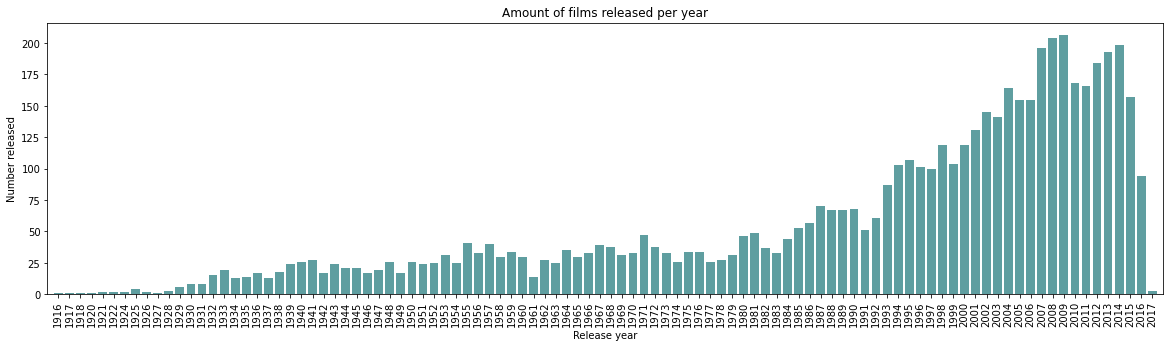

In [13]:
intersection_titles_dates = dict()
for i in intersection_indices:
    title = md_titles_dates_clean['title'][i]
    year = md_titles_dates_clean['release_date'][i][0:4]
    intersection_titles_dates[title] = year
    
#Plot date distribution (years)

years_overall = []
for date in intersection_titles_dates.values():
    years_overall.append(date)
years_overall.sort()
    
plt.figure(figsize=(20,5))
c = Counter(years_overall)
for year in c:
    plt.bar(year, c[year], color = "cadetblue")
plt.xlim(-1, 100)
plt.xticks(rotation=90)
plt.title("Amount of films released per year")
plt.xlabel("Release year")
plt.ylabel("Number released")
plt.show()

In [14]:
intersection_titles_dates = dict()
for i in intersection_indices:
    title = md_titles_dates_clean['title'][i]
    year = md_titles_dates_clean['release_date'][i][0:4]
    year = int(year)
    if year >= 1910 and year < 1930: # Combine 1910s and 1920s since 1910s is extremely small
        year = "1910-20s"
    elif year >= 1930 and year < 1940:
        year = "1930s"
    elif year >= 1940 and year < 1950:
        year = "1940s"
    elif year >= 1950 and year < 1960:
        year = "1950s"
    elif year >= 1960 and year < 1970:
        year = "1960s"
    elif year >= 1970 and year < 1980:
        year = "1970s"
    elif year >= 1980 and year < 1990:
        year = "1980s"
    elif year >= 1990 and year < 2000:
        year = "1990s"
    elif year >= 2000 and year < 2010:
        year = "2000s"
    elif year >= 2010:
        year = "2010s"
    intersection_titles_dates[title] = year
    
# print(len(intersection_titles_dates))
# print(intersection_titles_dates)

I extract the titles from the subtitle file names. Since these subtitles files are standalone and don't contain any metadata, it cannot be fully guaranteed that all subtitle file titles correspond to the match in "The Movies Database" data set. What I mean by this is that a title that I extract from the subtitle file could be incorrectly matched to a movie with the exact same name in The Movies Database, since duplicate names for films sometimes occur.

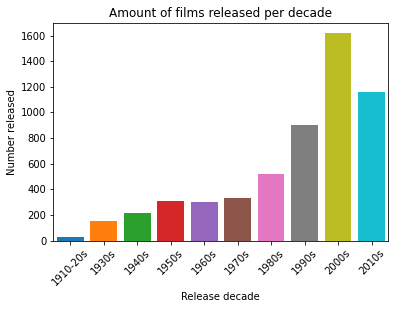

Counter({'2000s': 1616, '2010s': 1163, '1990s': 901, '1980s': 523, '1970s': 329, '1950s': 309, '1960s': 302, '1940s': 215, '1930s': 149, '1910-20s': 26})


In [15]:
#Plot date distribution (years)

years_aggregated = []
for date in intersection_titles_dates.values():
    years_aggregated.append(date)
years_aggregated.sort()
    
plt.figure()
c = Counter(years_aggregated)
for year in c:
    plt.bar(year, c[year])
plt.xlim(-0.5, 9.5)
plt.xticks(rotation=45)
plt.title("Amount of films released per decade")
plt.xlabel("Release decade")
plt.ylabel("Number released")
plt.show()
print(c)

### Balancing data/reducing amount of data

{'1980s': 523, '1990s': 901, '2000s': 1616, '2010s': 1163}


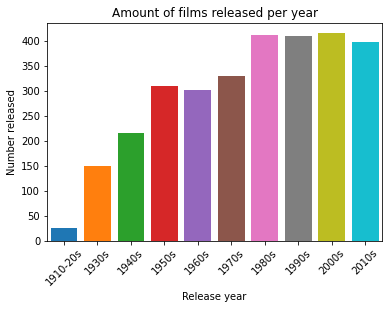

5533
2961


In [19]:
intersection_titles_dates_reduced = intersection_titles_dates.copy()

years = []
for date in intersection_titles_dates_reduced.values():
    years.append(date)
years.sort()
    
c = Counter(years)
    
large_years = dict()
for year in c:
    if c[year] > 400:
        large_years[year] = c[year]
print(large_years)

rg = np.random.default_rng(12345)
for film in intersection_titles_dates.keys():
    if intersection_titles_dates[film] in large_years.keys():
        rand = rg.random()
        if rand > (400/(large_years[intersection_titles_dates[film]])):
            intersection_titles_dates_reduced.pop(film)
            
        
            
years_reduced = []
for date in intersection_titles_dates_reduced.values():
    years_reduced.append(date)
years_reduced.sort()           

plt.figure()
c = Counter(years_reduced)
            
for year in c:
    plt.bar(year, c[year])
plt.xlim(-0.5, 9.5)
plt.xticks(rotation=45)
plt.title("Amount of films released per year")
plt.xlabel("Release year")
plt.ylabel("Number released")
plt.show()
print(len(intersection_titles_dates))
print(len(intersection_titles_dates_reduced))

In [20]:
titles_train, titles_test = sklearn.model_selection.train_test_split(list(intersection_titles_dates_reduced), test_size=0.15, random_state=0, stratify=years_reduced)

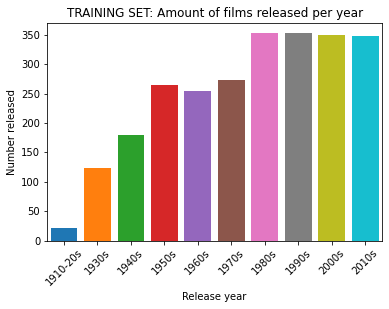

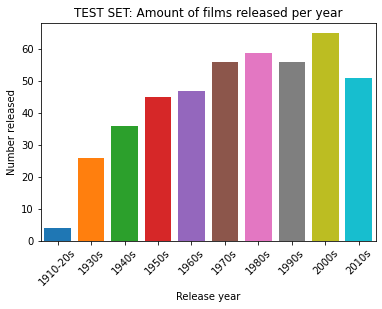

In [134]:
years_train = []
for title in titles_train:
    years_train.append(intersection_titles_dates_reduced[title])
years_train.sort()
    
plt.figure()
c = Counter(years_train)
for year in c:
    plt.bar(year, c[year])
plt.xlim(-0.5, 9.5)
plt.xticks(rotation=45)
plt.title("TRAINING SET: Amount of films released per year")
plt.xlabel("Release year")
plt.ylabel("Number released")
plt.show()

years_test = []
for title in titles_test:
    years_test.append(intersection_titles_dates_reduced[title])
years_test.sort()
    
plt.figure()
c = Counter(years_test)
for year in c:
    plt.bar(year, c[year])
plt.xlim(-0.5, 9.5)
plt.xticks(rotation=45)
plt.title("TEST SET: Amount of films released per year")
plt.xlabel("Release year")
plt.ylabel("Number released")
plt.show()

### SVM classifier

In [22]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tijs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tijs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tijs\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [130]:
# Extract features from a given text
def extract_features(text):
    bag_of_words = [x for x in wordpunct_tokenize(text)]
    sentences = [x for x in sent_tokenize(text)]
    POS_tags = [x for x in nltk.pos_tag(bag_of_words)]
    
    features = []

    
    
    # Average sentence length
    features.append(np.mean(np.array([len(wordpunct_tokenize(s)) for s in sentences])))

    
    
    # Lexicon size
    features.append(len(set(bag_of_words)))
    
    
    

    # All caps letter word count (e.g. use of USA, UDP or TCP)
    features.append(len([x for x in bag_of_words if all(c in x for c in string.ascii_uppercase)]))

    
    ### PoS tags
    
    # PoS tags frequency:
    tags = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNPS','NNS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']
    tag_occurrences = dict.fromkeys(tags, 0)
    for tag in POS_tags:
        if tag[1] not in string.punctuation and tag[1] != "''" and tag[1] != "``":
            tag_occurrences[tag[1]] += 1
    for tag in tags:
        features.append(tag_occurrences[tag])
    
    
    
    
    
    ### Function words
    
    # Function words frequency (list of function words from https://doi.org/10.1002/asi.20316)
    function_words = ['a','between','in','nor','some','upon','about','both','including','nothing','somebody','us','above','but','inside','of','someone','used','after','by','into','off','something','via','all','can','is','on','such','we','although','cos','it','once','than','what','am','do','its','one','that','whatever','among','down','latter','onto','the','when','an','each','less','opposite','their','where','and','either','like','or','them','whether','another','enough','little','our','these','which','any','every','lots','outside','they','while','anybody','everybody','many','over','this','who','anyone','everyone','me','own','those','whoever','anything','everything','more','past','though','whom','are','few','most','per','through','whose','around','following','much','plenty','till','will','as','for','must','plus','to','with','at','from','my','regarding','toward','within','be','have','near','same','towards','without','because','he','need','several','under','worth','before','her','neither','she','unless','would','behind','him','no','should','unlike','yes','below','i','nobody','since','until','you','beside','if','none','so','up','your']
    function_word_occurrences = dict.fromkeys(function_words, 0)
    for word in bag_of_words:
        if word in function_words:
            function_word_occurrences[word] += 1
    for func_word in function_words:
        features.append(function_word_occurrences[func_word])

    return features

In [131]:
train_data = [titles_subs[x] for x in titles_train]
train_targets = [intersection_titles_dates_reduced[x] for x in titles_train]

# Extract the features
features = list(map(lambda text: extract_features(text), train_data))

In [242]:
# Make subset of features for ablation analysis, all occurrences of variable 'features' in cell below must be replaced
# with features_subset if ablation below is desired

# features_subset = np.array(features.copy())
# features_subset = np.delete(features_subset, (range(39, 189)), axis=1) # Deletes features in supplied indices
# print(features_subset.shape)

In [247]:
# Parts of the code below were taken from the TxMM assignment on authorship attribution
# Classify using the features
def classify(train_features, train_labels, test_features):
    clf = sklearn.svm.LinearSVC(dual=False, class_weight='balanced', max_iter=10000)
#     clf = sklearn.linear_model.SGDClassifier(class_weight='balanced')
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)


# Evaluate predictions (y_pred) given the ground truth (y_true)
def evaluate(y_true, y_pred):
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
    print("Recall: %f" % recall)

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
    print("Precision: %f" % precision)
    
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print("Accuracy: %f" % accuracy)

    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    print("F1-score: %f" % f1_score)
    
    print(y_true)
    print(y_pred)
    
    return recall, precision, accuracy, f1_score


# The main program
def main():
#     train_data = [titles_subs[x] for x in titles_train]
#     train_targets = [intersection_titles_dates_reduced[x] for x in titles_train]

    # Extract the features
#     features = list(map(lambda text: extract_features(text), train_data))
   
    ###### Feature extraction above is done in separate cell above ######
    
    

    # Classify and evaluate
    skf = sklearn.model_selection.StratifiedKFold(n_splits=10)
    scores = []
    mistakes = []
    for fold_id, (train_indexes, validation_indexes) in enumerate(skf.split(titles_train, train_targets)):
        # Print the fold number
        print("Fold %d" % (fold_id + 1))

        # Collect the data for this train/validation split
        train_features = [features[x] for x in train_indexes]
        train_labels = [train_targets[x] for x in train_indexes]
        validation_features = [features[x] for x in validation_indexes]
        validation_labels = [train_targets[x] for x in validation_indexes]

        # Classify and add the scores to be able to average later
        y_pred = classify(train_features, train_labels, validation_features)
        scores.append(evaluate(validation_labels, y_pred))

        # Print a newline
        print("")

    # Print the averaged score
    recall = sum([x[0] for x in scores]) / len(scores)
    print("Averaged total recall", recall)
    precision = sum([x[1] for x in scores]) / len(scores)
    print("Averaged total precision", precision)
    acc_score = sum([x[2] for x in scores]) / len(scores)
    print("Averaged total accuracy", acc_score)
    f_score = sum([x[3] for x in scores]) / len(scores)
    print("Averaged total f-score", f_score)
    print("")
    

#     test_data = [titles_subs[x] for x in titles_test]
#     test_targets = [intersection_titles_dates_reduced[x] for x in titles_test]
    
#     test_features = list(map(lambda text: extract_features(text), test_data))
    
#     y_pred = classify(features, train_targets, test_features)
#     evaluate(test_targets, y_pred)

In [248]:
main()

Fold 1


c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.268880
Precision: 0.267152
Accuracy: 0.293651
F1-score: 0.263888
['1960s', '1940s', '1960s', '1990s', '2010s', '1990s', '1960s', '1940s', '2010s', '1970s', '1960s', '1980s', '1970s', '1990s', '1930s', '1930s', '2010s', '1990s', '1980s', '1980s', '1990s', '1940s', '2000s', '1960s', '1970s', '1960s', '1970s', '2000s', '1990s', '1960s', '2010s', '1940s', '1950s', '1980s', '1980s', '1990s', '1950s', '1960s', '1950s', '1990s', '2010s', '1950s', '2010s', '1980s', '1980s', '1970s', '1990s', '2000s', '1960s', '1990s', '1930s', '1940s', '1970s', '2010s', '1950s', '2000s', '1990s', '1950s', '2000s', '1980s', '1940s', '2010s', '2000s', '1990s', '1950s', '1960s', '1930s', '2010s', '1990s', '2010s', '1980s', '1980s', '1970s', '2000s', '2000s', '1990s', '2000s', '1980s', '1940s', '1940s', '2000s', '1940s', '2010s', '1980s', '1940s', '1980s', '1990s', '2010s', '1950s', '1980s', '1950s', '1970s', '1930s', '1990s', '1950s', '1990s', '2000s', '2010s', '2010s', '1950s', '1930s', '1960s', '2010s

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.234681
Precision: 0.236910
Accuracy: 0.257937
F1-score: 0.229317
['1940s', '1940s', '1940s', '1940s', '1940s', '1910-20s', '1940s', '1990s', '1990s', '1940s', '1990s', '1990s', '1940s', '1990s', '1990s', '1940s', '1990s', '1950s', '1940s', '1990s', '1990s', '1980s', '1950s', '1940s', '1990s', '1950s', '1990s', '1990s', '1990s', '1950s', '1950s', '1950s', '1980s', '1980s', '1990s', '1950s', '1940s', '1940s', '1950s', '1980s', '1990s', '1980s', '1980s', '1990s', '1930s', '1990s', '1940s', '2000s', '1950s', '1960s', '1990s', '2000s', '1980s', '1950s', '1930s', '1990s', '1980s', '2000s', '1990s', '1970s', '1960s', '1960s', '2010s', '1960s', '2010s', '1980s', '1940s', '2000s', '2000s', '1940s', '2010s', '2010s', '1950s', '1990s', '1980s', '2000s', '1950s', '1980s', '1930s', '2010s', '2010s', '1940s', '1990s', '2000s', '1970s', '1990s', '1980s', '1930s', '2010s', '1960s', '2010s', '1990s', '1950s', '2010s', '1980s', '1990s', '1960s', '2000s', '1990s', '1930s', '1960s', '1930s', '19

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.272770
Precision: 0.271010
Accuracy: 0.289683
F1-score: 0.267864
['1940s', '1940s', '1940s', '1940s', '1990s', '1990s', '1990s', '1940s', '1940s', '1940s', '1990s', '1990s', '1990s', '1940s', '1940s', '1940s', '1990s', '1990s', '1940s', '1990s', '1990s', '1940s', '1950s', '1940s', '1940s', '1940s', '1950s', '1990s', '1990s', '1950s', '1990s', '1990s', '1990s', '1950s', '1940s', '1940s', '1990s', '1950s', '1990s', '1940s', '1910-20s', '1990s', '1990s', '1990s', '1990s', '2010s', '2010s', '1990s', '1990s', '1950s', '2010s', '1950s', '1950s', '2010s', '2010s', '2010s', '1980s', '1950s', '1990s', '1990s', '2000s', '1980s', '2000s', '2010s', '2000s', '1950s', '2000s', '1990s', '2010s', '2000s', '2010s', '1950s', '2010s', '2000s', '2000s', '2010s', '2010s', '2010s', '1960s', '2000s', '1950s', '1980s', '1960s', '1950s', '2000s', '1930s', '1970s', '1980s', '2010s', '1930s', '2000s', '1950s', '2010s', '1990s', '1960s', '1960s', '2010s', '2010s', '2010s', '2000s', '1950s', '1980s', '19

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.277049
Precision: 0.274521
Accuracy: 0.321429
F1-score: 0.272121
['1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '2010s', '1990s', '1990s', '1990s', '2010s', '2010s', '1940s', '2010s', '2010s', '1910-20s', '2010s', '1950s', '1950s', '1940s', '2010s', '2010s', '1950s', '2010s', '1950s', '1950s', '2010s', '2010s', '1990s', '1990s', '2010s', '1990s', '1930s', '1990s', '1940s', '1960s', '1960s', '2010s', '1960s', '2010s', '1930s', '1950s', '2010s', '1960s', '1950s', '1960s', '1940s', '1930s', '2010s', '2010s', '1990s', '1990s', '1960s', '1990s', '1960s', '1950s', '1990s', '2010s', '2010s', '1980s', '2000s', '2010s', '1950s', '1950s', '2000s', '2000s', '2000s', '1960s', '1960s', '2000s', '1950s', '1940s', '2010s', '1990s', '2000s', '2010s', '1960s', '1950s', '1940s', '1990s', '1930s', '1990s', '1940s', '1980s', '1940s', '1960s', '1980s', '1990s', '1980s', '1980s', '1980s', '2000s', '1930s', '1970s', '1940s', '1950s', '1990s', '1970s', '1980s', '19

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.264350
Precision: 0.246438
Accuracy: 0.261905
F1-score: 0.243744
['1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1960s', '1960s', '1940s', '1960s', '1990s', '1940s', '1940s', '1990s', '1960s', '1990s', '1960s', '1990s', '1930s', '1940s', '1930s', '2010s', '2010s', '1990s', '1940s', '1990s', '2010s', '1990s', '1990s', '1990s', '2010s', '1950s', '2010s', '2010s', '2010s', '1990s', '1940s', '1960s', '2010s', '1950s', '2010s', '2010s', '1950s', '1930s', '1990s', '1950s', '1950s', '1930s', '1940s', '1910-20s', '1990s', '1990s', '1940s', '1910-20s', '1990s', '1990s', '2010s', '1950s', '1950s', '1960s', '1950s', '2010s', '1990s', '1950s', '1980s', '1980s', '2010s', '1980s', '1980s', '1980s', '1980s', '1950s', '1980s', '1980s', '2000s', '1930s', '1950s', '1950s', '1950s', '1990s', '1980s', '1980s', '1980s', '2010s', '2000s', '1930s', '2000s', '2000s', '1980s', '2000s', '2000s', '1990s', '1990s', '1980s', '1980s', '1950s', '1960s', '1980s', '1960s', 

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.318874
Precision: 0.318093
Accuracy: 0.361111
F1-score: 0.314231
['1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1940s', '1950s', '1950s', '1940s', '1950s', '2010s', '2010s', '1950s', '2010s', '1990s', '1960s', '1950s', '1960s', '1990s', '1960s', '1940s', '2010s', '1980s', '2010s', '1980s', '1990s', '2010s', '2010s', '1990s', '1960s', '1990s', '1990s', '1980s', '2010s', '1990s', '1950s', '2010s', '1990s', '2010s', '2010s', '1960s', '1990s', '1980s', '1960s', '2010s', '2010s', '1960s', '1990s', '1990s', '1990s', '1960s', '1980s', '1950s', '2010s', '2010s', '1990s', '1990s', '1990s', '1950s', '2010s', '2010s', '2000s', '1980s', '2010s', '2000s', '2000s', '1980s', '2000s', '1960s', '1910-20s', '1910-20s', '2010s', '2000s', '1960s', '2010s', '1980s', '1960s', '2010s', '1980s', '1950s', '1960s', '1940s', '2000s', '1980s', '1930s', '2010s', '1980s', '1960s', '2010s', '1980s', '1930s', '1930s', '1990s', '1980s', '1990s', '1990s', '2010s', '1950s', 

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.315027
Precision: 0.317354
Accuracy: 0.334661
F1-score: 0.305915
['2010s', '2010s', '1960s', '2010s', '2010s', '1960s', '2010s', '2010s', '2010s', '2010s', '2010s', '2010s', '2010s', '1960s', '1910-20s', '2010s', '1990s', '1990s', '2010s', '1940s', '1980s', '2010s', '1980s', '1960s', '1980s', '1960s', '1990s', '1940s', '2010s', '1940s', '1990s', '1980s', '2010s', '1960s', '2010s', '1990s', '1990s', '1990s', '1940s', '2000s', '1960s', '2000s', '2000s', '1960s', '2000s', '1990s', '1990s', '2000s', '2000s', '1960s', '2000s', '1940s', '1960s', '1980s', '1980s', '1980s', '1980s', '1940s', '1960s', '2000s', '1990s', '1990s', '1990s', '2010s', '2010s', '1960s', '1990s', '1950s', '1990s', '1950s', '1990s', '1980s', '1940s', '1990s', '2000s', '2000s', '2010s', '1980s', '2010s', '1940s', '1960s', '1950s', '1940s', '1980s', '1940s', '2010s', '1980s', '1950s', '1950s', '2010s', '1950s', '1990s', '1950s', '1950s', '1970s', '1980s', '1970s', '2000s', '1980s', '1960s', '2000s', '1980s', '19

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.276130
Precision: 0.247937
Accuracy: 0.286853
F1-score: 0.253273
['2010s', '1940s', '1940s', '2010s', '2010s', '2010s', '2010s', '1910-20s', '1940s', '1990s', '2010s', '1980s', '1940s', '2010s', '2010s', '1940s', '1940s', '2010s', '1940s', '1990s', '2010s', '1960s', '1960s', '1990s', '1950s', '1990s', '1960s', '1990s', '1960s', '1960s', '1960s', '1960s', '1980s', '2000s', '2000s', '2000s', '1980s', '2000s', '2010s', '1950s', '1940s', '2010s', '1930s', '2010s', '1960s', '2000s', '1950s', '2000s', '1980s', '1990s', '2010s', '1990s', '1990s', '1980s', '1990s', '2000s', '1940s', '1990s', '1980s', '1980s', '1950s', '2000s', '1950s', '2010s', '1990s', '1980s', '2000s', '1960s', '2000s', '2010s', '1980s', '1940s', '2010s', '1980s', '1990s', '2010s', '1970s', '1980s', '1930s', '1970s', '1990s', '1960s', '1960s', '2000s', '2010s', '2010s', '1950s', '1940s', '1980s', '1960s', '1930s', '1940s', '1950s', '2010s', '1940s', '1970s', '2010s', '2000s', '1980s', '2010s', '1960s', '1970s', '20

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 0.279249
Precision: 0.237803
Accuracy: 0.250996
F1-score: 0.240006
['1910-20s', '1910-20s', '1960s', '1960s', '1960s', '2010s', '2010s', '1940s', '1960s', '2010s', '1950s', '1950s', '1940s', '2010s', '1950s', '2010s', '1960s', '2010s', '1960s', '1950s', '2010s', '1950s', '1940s', '2000s', '1990s', '2010s', '1950s', '1940s', '2010s', '1960s', '1980s', '1980s', '1990s', '1950s', '2000s', '1930s', '2000s', '2010s', '1980s', '1960s', '1940s', '1940s', '1930s', '1970s', '1990s', '1970s', '2010s', '2000s', '1950s', '1980s', '1940s', '1980s', '1960s', '2000s', '1990s', '1990s', '2000s', '1990s', '1970s', '1950s', '1950s', '1970s', '2000s', '2000s', '1990s', '1970s', '2000s', '1970s', '2010s', '1940s', '1970s', '2010s', '1980s', '1960s', '1980s', '2010s', '1950s', '1960s', '2010s', '2000s', '1960s', '2000s', '1950s', '1950s', '1960s', '1950s', '1970s', '1990s', '1970s', '1980s', '1940s', '2010s', '1990s', '1930s', '1940s', '1980s', '1970s', '1950s', '1960s', '1960s', '1940s', '1950s', 

c:\users\tijs\miniconda3\envs\txmm\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Ablation analysis

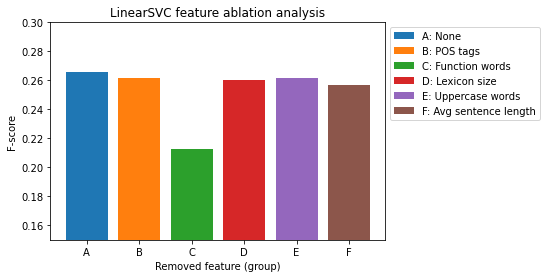

In [231]:
# Ablation analysis f-scores
none_removed = 0.26583086234482156
pos_removed = 0.26133126091868364
func_words_removed = 0.21269183271797515
lex_size_removed = 0.2605081003315607
uppcase_word_removed = 0.261393954371249
avgsentlen_removed = 0.25707297873462986

ablations = [none_removed, pos_removed, func_words_removed, lex_size_removed, uppcase_word_removed, avgsentlen_removed]
ablation_labels = ["A: None", "B: POS tags", "C: Function words", "D: Lexicon size", "E: Uppercase words", "F: Avg sentence length"]
ablation_xaxis = ['A','B','C','D','E','F']

plt.figure("""figsize=(10,5)""")
for i in range(len(ablations)):
    plt.bar(ablation_xaxis[i], ablations[i])
plt.ylim((0.15, 0.3))
plt.legend(ablation_labels, bbox_to_anchor=(1.00, 1))
plt.title("LinearSVC feature ablation analysis")
plt.xlabel("Removed feature (group)")
plt.ylabel("F-score")
plt.show()